<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно.   
Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.  
Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.   

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. 
Проверьте *F1*-меру на тестовой выборке самостоятельно.    

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.  

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных
Признаки  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
Целевой признак  
Exited — факт ухода клиента  

In [2]:
!pip install scikit-learn==1.1.3
!pip install imblearn

     |████████████████████████████████| 30.8 MB 49 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 226 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 14.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    recall_score,
    precision_score,
    mean_squared_error, 
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    roc_auc_score 
)


## Подготовка данных

In [4]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.head())
print(data.info())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

Открыли файл, прочитали первые 5 строк и изучили информацию о датасете, пропуски имеются только в столбце Tenure.

In [5]:
print(data['Exited'].value_counts())

0    7963
1    2037
Name: Exited, dtype: int64


Посмотрим на соотношение 0 и 1 в целевом признаке. Соотношение примерно 1 к 4, выборка не сбалансирована. 

In [6]:
print(data.drop(['RowNumber'], axis=1).duplicated().sum())

0


Видим, что в данных отсутствуют явные дубликаты

In [7]:
data = data.dropna(subset=['Tenure'])

Строки, где отсутствуют значения в столбце Tenure, составляют примерно 10% от объема данных, мы не можем заполнить пропуски значениями, поэтому решила удалить эти строки. 

In [8]:
data=data.drop(['Surname','RowNumber','CustomerId'], axis=1)

Удалила из датасета признаки, которые не участвуют в анализе. 

In [9]:
features =  data.drop('Exited', axis=1)
target = data['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(data.head())

(5454, 10)
(1819, 10)
(1818, 10)
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42     2.0       0.00              1   
1          608     Spain  Female   41     1.0   83807.86              1   
2          502    France  Female   42     8.0  159660.80              3   
3          699    France  Female   39     1.0       0.00              2   
4          850     Spain  Female   43     2.0  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


Разделила выборку на обучающую, валидационную и тестовую, посмотрела размеры получившихся выборок.

In [10]:

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']
ohe_features= list(set(features_train) - set(numeric))
ohe_features

['HasCrCard', 'Geography', 'IsActiveMember', 'Gender']

Создали список категориальных признаков чтобы применить OHE кодирование. 

In [11]:

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train[ohe_features])

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

features_train = features_train.drop(ohe_features, axis=1)

features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

features_train.head()
features_valid.head()
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard_1,Geography_Germany,Geography_Spain,IsActiveMember_1,Gender_Male
7445,516,45,4.0,0.00,1,95273.73,1.0,0.0,0.0,0.0,0.0
8620,768,40,8.0,0.00,2,69080.46,0.0,0.0,0.0,1.0,0.0
1714,730,45,6.0,152880.97,1,162478.11,0.0,1.0,0.0,0.0,1.0
5441,751,29,1.0,135536.50,1,66825.33,1.0,0.0,0.0,0.0,1.0
9001,688,32,6.0,124179.30,1,138759.15,1.0,0.0,1.0,1.0,1.0


Масштабирование количественных признаков

In [12]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 
print(features_train.head())

      CreditScore       Age    Tenure   Balance  NumOfProducts  \
9344     0.809075 -1.039327 -1.025995  0.554904      -0.908179   
3796    -1.152518 -1.227561  0.696524  0.480609      -0.908179   
7462    -0.398853  0.090079  1.385532 -1.237830      -0.908179   
1508    -0.749875 -0.286389  0.352020 -1.237830       0.809300   
4478    -1.028628 -0.756975 -0.336987 -1.237830       0.809300   

      EstimatedSalary  HasCrCard_1  Geography_Germany  Geography_Spain  \
9344         0.019508          1.0                0.0              0.0   
3796         0.056167          0.0                0.0              0.0   
7462         0.848738          1.0                0.0              0.0   
1508        -0.894953          1.0                0.0              0.0   
4478        -1.284516          0.0                0.0              0.0   

      IsActiveMember_1  Gender_Male  
9344               0.0          0.0  
3796               0.0          1.0  
7462               1.0          1.0  
1508  

Рассмотрим модель случайного леса и попробуем подобрать оптимальные гиперпараметры

In [13]:
best_model = None
best_depth = 0
best_result=0
best_est = 0
for est in range(10, 101, 10):
    for depth in range(1, 31):
        model = RandomForestClassifier(max_depth=depth,n_estimators=est, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_est = est
        
print('best_depth =',best_depth,'best_est =',best_est,'f1_score =',best_result)
model = RandomForestClassifier(random_state=12345, max_depth=best_depth,n_estimators=best_est) 


best_depth = 30 best_est = 40 f1_score = 0.5880281690140844


Наилучший результат (судя по метрике f1) дает модель случайного леса со следующими гиперпараметрами: max_depth=30 ,n_estimators=80. 

In [17]:
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ', auc_roc)

ROC-AUC =  0.8496500850043085


Проверим модель на адекватность: сравним ее с dummy моделью.

In [52]:
clf_dummy = DummyClassifier(random_state=12345) 
clf_dummy.fit(features_train, target_train) 
predictions_valid = clf_dummy.predict(features_valid) 
result = f1_score(target_valid, predictions_valid)
probabilities_valid = clf_dummy.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)
print("F1 =",result)

ROC-AUC =  0.5
F1 = 0.0


Метрика f1 нашей модели выше чем у dummy модели, но еще очень далека от идеала. 

Теперь рассмотрим модель логистической регрессии и попробуем подобрать оптимальные гиперпараметры 

In [19]:
best_model = None
best_iteration = 0
best_result=0
best_C = 0
for iteration in range(100, 1000, 100):
    for ipr in range(1,10):
        model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iteration,C=ipr) 
        model.fit(features_train, target_train) 
        predictions_valid=model.predict(features_valid) 
        result=f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_iteration = iteration
        best_C = ipr

print("F1 =",result)
print('max_iter =',best_iteration,'C =',best_C)

F1 = 0.32119914346895073
max_iter = 100 C = 9


In [20]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)

ROC-AUC =  0.7810052244657151


У логистической регрессии метрика f1 максимальна при max_iter = 100 C = 9

## Борьба с дисбалансом

Даунсемплинг

In [34]:

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)



Вновь подберем оптимальные параметры для логистической регрессии и случайного леса. 

Логистическая регрессия

In [35]:
best_model = None
best_iteration = 0
best_result=0
best_C = 0
for iteration in range(100, 1000, 100):
    for ipr in range(1,10):
        model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iteration,C=ipr) 
        model.fit(features_downsampled, target_downsampled)
        predictions_valid=model.predict(features_valid) 
        result=f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_iteration = iteration
        best_C = ipr
print("F1 =",result)
print('max_iter =',best_iteration,'C =',best_C)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)

F1 = 0.37415730337078656
max_iter = 100 C = 9
ROC-AUC =  0.7827926438280661


Случайный лес

In [36]:
best_model = None
best_depth = 0
best_result=0
best_est = 0
for est in range(10, 101, 10):
    for depth in range(1, 31):
        model = RandomForestClassifier(max_depth=depth,n_estimators=est, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_est = est
        


print('best_depth =',best_depth,'best_est =',best_est,'f1_score =',best_result)

best_depth = 30 best_est = 40 f1_score = 0.5258467023172905


In [37]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)

ROC-AUC =  0.8433106655177499


Апсемплинг 

In [43]:
oversample = SMOTE(random_state=1234)

features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)


In [44]:

features_train.shape

(8656, 11)

Случайный лес

In [45]:
best_model = None
best_depth = 0
best_result=0
best_est = 0
for est in range(10, 101, 10):
    for depth in range(1, 31):
        model = RandomForestClassifier(max_depth=depth,n_estimators=est, random_state=12345)
        model.fit(features_train_up, target_train_up)
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_est = est
        
print('best_depth =',best_depth,'best_est =',best_est,'f1_score =',best_result)

best_depth = 30 best_est = 40 f1_score = 0.60882800608828


In [51]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)

ROC-AUC =  0.8429758882756158


Логистическая регрессия

In [42]:
best_model = None
best_iteration = 0
best_result=0
best_C = 0
for iteration in range(100, 1000, 100):
    for ipr in range(1,10):
        model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iteration,C=ipr) 
        model.fit(features_train_up, target_train_up) 
        predictions_valid=model.predict(features_valid) 
        result=f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_iteration = iteration
        best_C = ipr
print("F1 =",result)
print('max_iter =',best_iteration,'C =',best_C)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)

F1 = 0.5025536261491318
max_iter = 100 C = 9
ROC-AUC =  0.7833981539703612


Наилучшая метрика f1 = 0.6088 получилась у модели случайного леса со следующими параметрами:   
best_depth = 30 best_est = 40 

In [46]:
model = RandomForestClassifier(max_depth=30,n_estimators=40, random_state=12345)
model.fit(features_train_up, target_train_up) 

RandomForestClassifier(max_depth=30, n_estimators=40, random_state=12345)

Посмотрим на качество модели на графиках

ROC-AUC =  0.8429758882756158


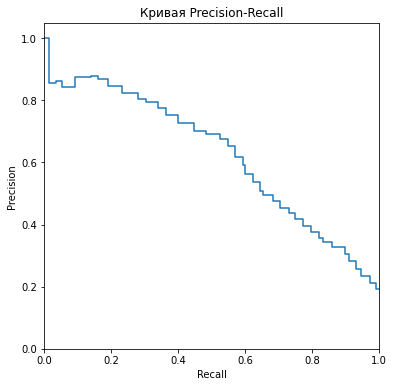

In [50]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print('ROC-AUC = ',auc_roc)

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

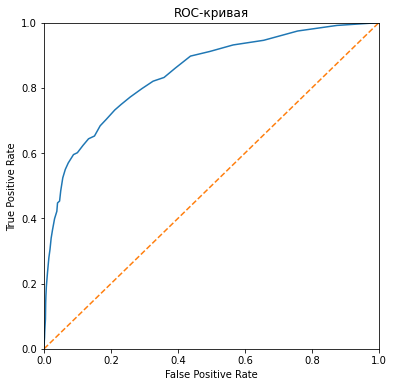

In [48]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

## Тестирование модели

In [53]:
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.6129496402877699


In [54]:
print(confusion_matrix(target_valid, predicted_valid))

print(recall_score(target_valid,predicted_valid)) # полнота

print(precision_score(target_valid,predicted_valid)) #точность

[[1358  110]
 [ 153  198]]
0.5641025641025641
0.6428571428571429


Модель случайного леса с подобранными гиперпараметрами показала себя хорошо на тестовой выборке. Метрика F1: 0.6129

Вывод:    
модель случайного леса предсказывает целевой признак (уход человека из банка) с точностью 0.64.  
Качество модель гораздо выше по сравнению с dummy моделью.  
Оптимальные гиперпараметры: max_depth=30,n_estimators=40.    
Метрика F1: 0.6129  


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*